# AI Fundamentals: Hands-on workshop on Data Wrangling

## Tissue segmentation, stain normalisation and stain augmentation

In this notebook we will be working with two WSIs with different stain appearance. To view each ofthese WSIs in a viewer use the links below: <br /> 
https://portal.gdc.cancer.gov/files/48ab91f1-dd5c-4e67-8e52-61334afcb1fc <br />
https://portal.gdc.cancer.gov/files/639c3cbc-965a-40fc-bd7f-14cc6be7c3ab <br />

In the notebook we shall:

- View the images at low resolution
- Generate a tissue mask for each of the images
- Extract a sample of patches  from each WSI
- Normalise patches to a target image region

In [1]:
# import libraries
import openslide
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 

# import scripts 
from gen_tissue_mask import *
from extract_patches import *
from stain_normalise_tiles import *

In [2]:
# Set paths

wsi_path = '/home/simon/Desktop/stain_repo/data/wsi'
output_tissue_dir = '/home/simon/Desktop/stain_repo/output/tissueMask/'
output_patches_dir = '/home/simon/Desktop/stain_repo/output/patches/'

sn_input_dir = '/home/simon/Desktop/stain_repo/output/patches/'
sn_output_dir = '/home/simon/Desktop/stain_repo/output/sn_patches/'

In [3]:
# Display each of the slides at low resolution (thumbnail)

list_wsi = glob.glob(wsi_path + '/*') # get list of files in directory
num_wsi = len(list_wsi)

thumbnail_list = []
for wsi in list_wsi:
    wsi_obj = openslide.OpenSlide(wsi) # create openslide object
    print('Getting WSI attributes for ',os.path.basename(wsi))
    print('Objective power :', np.int(wsi_obj.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER]))
    print('Level dimensions :', wsi_obj.level_dimensions)
    print('Level downsamples :', wsi_obj.level_downsamples)
    print('Level count :', wsi_obj.level_count)
    thumbnail_list.append(wsi_obj.get_thumbnail(wsi_obj.level_dimensions[-1])) # get thumbnail at lowest available resolution 
    print('---------------------------------------------------------------------')
    
    

Getting WSI attributes for  TCGA-BH-A0W4-01Z-00-DX1.23E017DC-15CB-4838-AC91-CFB11B932AB0.svs
Objective power : 40
Level dimensions : ((126401, 90976), (31600, 22744), (7900, 5686), (3950, 2843))
Level downsamples : (1.0, 4.00001582278481, 16.00006329113924, 32.00012658227848)
Level count : 4
---------------------------------------------------------------------
Getting WSI attributes for  TCGA-A8-A0A1-01Z-00-DX1.CA64E221-E2A8-42B5-B611-25B9FE5FB0B0.svs
Objective power : 20
Level dimensions : ((53504, 86784), (13376, 21696), (3344, 5424), (1672, 2712))
Level downsamples : (1.0, 4.0, 16.0, 32.0)
Level count : 4
---------------------------------------------------------------------


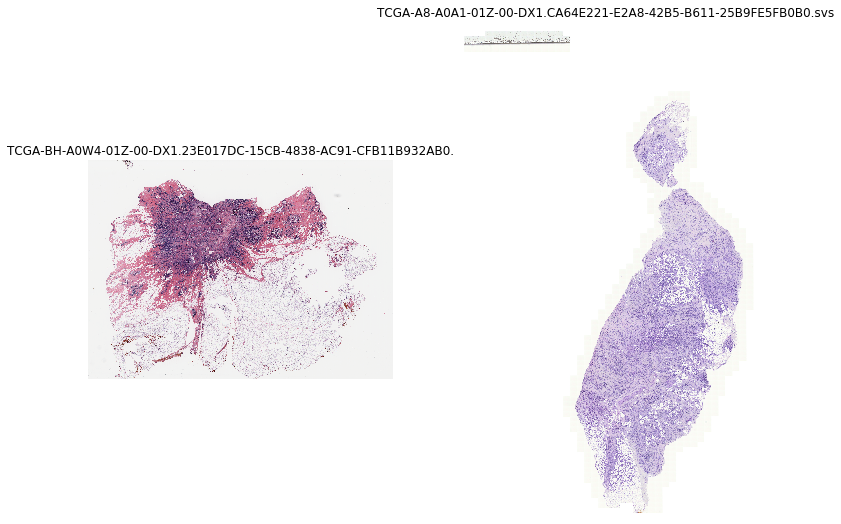

In [4]:
# plot the thumbnails

def plot_figs(list_, clrmap=None):
    plt.figure(figsize=(12,12))
    for idx in range(num_wsi):
        plt.subplot(1, num_wsi, idx+1)
        plt.imshow(list_[idx], cmap=clrmap)
        plt.title(os.path.basename(list_wsi[idx]))
        plt.axis('off')
    plt.show()

plot_figs(thumbnail_list)

## For each low resolution WSI image, create the tissue mask  

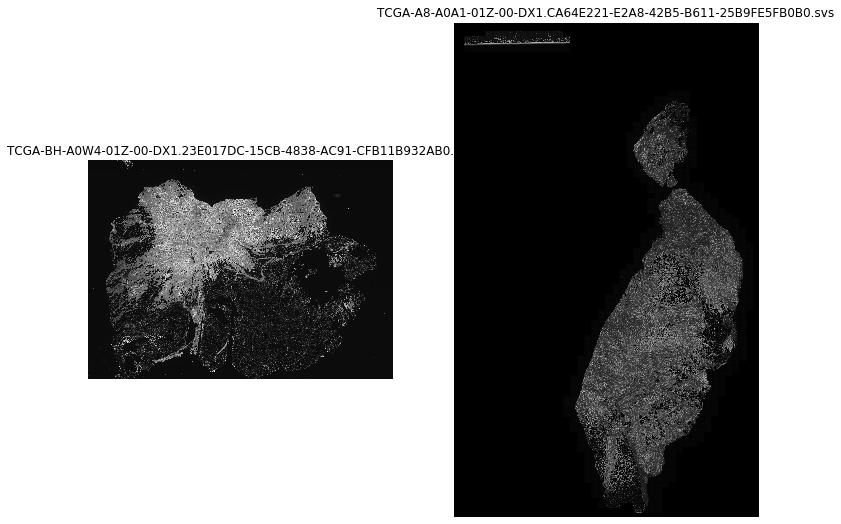

In [5]:
# First convert WSI to grayscale

gray_list = []
for idx in range(num_wsi):
    wsi_lowres = thumbnail_list[idx]
    wsi_lowres = np.array(wsi_lowres) # convert to numpy array
    tmp = cv2.cvtColor(wsi_lowres, cv2.COLOR_RGB2GRAY)
    gray_list.append(255-cv2.cvtColor(wsi_lowres, cv2.COLOR_RGB2GRAY))

plot_figs(gray_list, clrmap=cm.gray) 

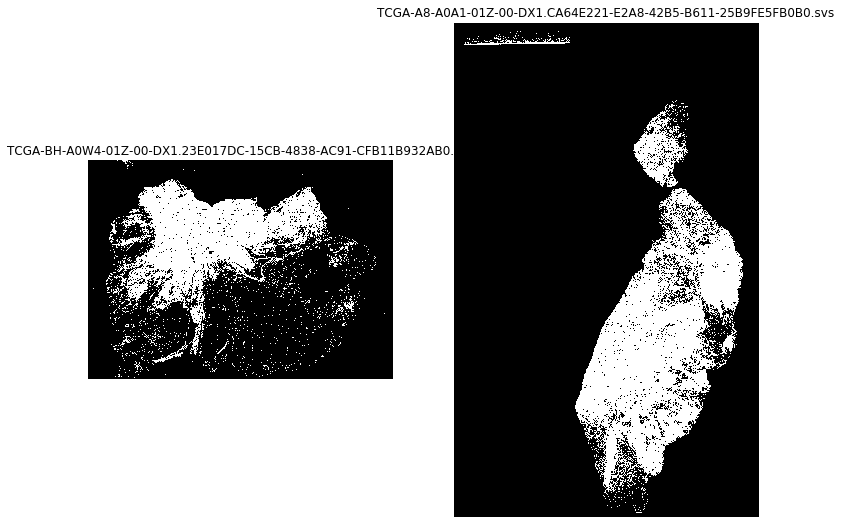

In [6]:
# Threshold greyscale WSI by otsu threshold
thresh_list1 = []
for idx in range(num_wsi):
    wsi_gray = gray_list[idx]
    _, wsi_thresh = cv2.threshold(wsi_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh_list1.append(wsi_thresh)

plot_figs(thresh_list1, clrmap=cm.gray) 

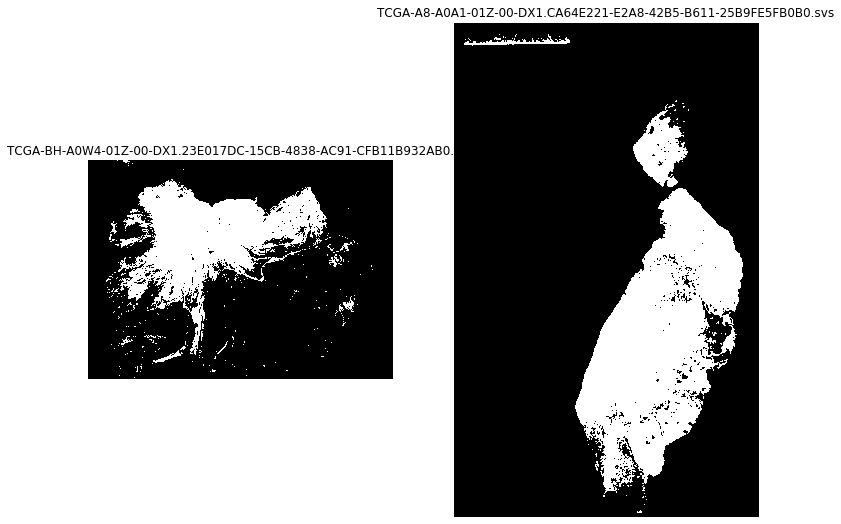

In [7]:
# Threshold greyscale WSI by otsu threshold  -> blur image before threshold
thresh_list2 = []
for idx in range(num_wsi):
    wsi_gray = gray_list[idx]
    blur = cv2.GaussianBlur(wsi_gray,(15,15),0) 
    _, wsi_thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh_list2.append(wsi_thresh)

plot_figs(thresh_list2, clrmap=cm.gray) 

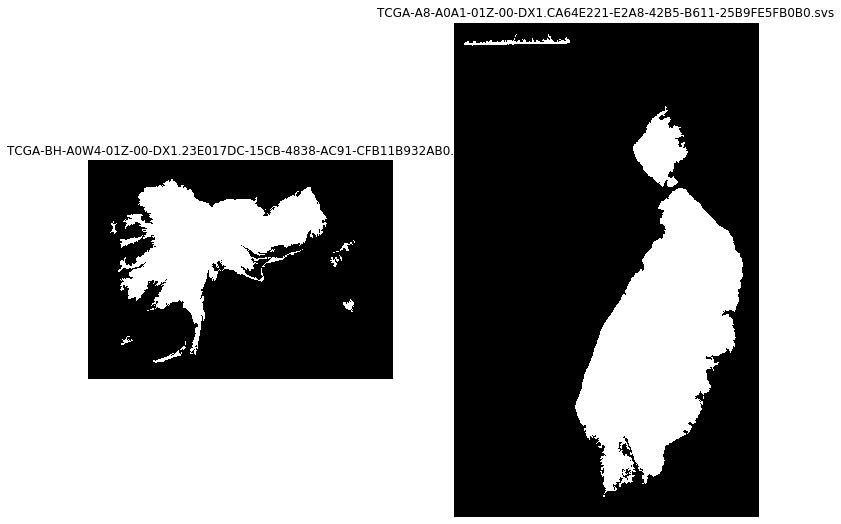

In [8]:
# Fill holes and remove small objects
from skimage.morphology import remove_small_objects

thresh_list3 = []
for idx in range(num_wsi):
    wsi_gray = gray_list[idx]
    blur = cv2.GaussianBlur(wsi_gray,(15,15),0) 
    _, wsi_thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    wsi_thresh = wsi_thresh
    wsi_thresh = scipy.ndimage.binary_fill_holes(wsi_thresh) # fill holes
    wsi_thresh = remove_small_objects(wsi_thresh, min_size=5000, connectivity=1) # remove smal objects
    thresh_list3.append(wsi_thresh)

plot_figs(thresh_list3, clrmap=cm.gray)

## Extract patches from each WSI
    

In [9]:
extract_patches(wsi_path,
        output_dir=output_patches_dir,
        file_name_pattern='*.svs',
        num_cpu=4,
        tile_objective_value=20,
        tile_read_size_w=2000,
        tile_read_size_h=2000,
        nr_tiles=8,
        tiss_level=3,
        use_tiss_mask=True,
        tiss_cutoff = 0.5
        )

Extracting patches from TCGA-A8-A0A1-01Z-00-DX1.CA64E221-E2A8-42B5-B611-25B9FE5FB0B0.svs
Extracting patches from TCGA-BH-A0W4-01Z-00-DX1.23E017DC-15CB-4838-AC91-CFB11B932AB0.svs
Tile0:  start_w:36000, end_w:38000, start_h:32000, end_h:34000, width:2000, height:2000
Tile1:  start_w:38000, end_w:40000, start_h:40000, end_h:42000, width:2000, height:2000
Tile2:  start_w:40000, end_w:42000, start_h:70000, end_h:72000, width:2000, height:2000
Tile3:  start_w:46000, end_w:48000, start_h:48000, end_h:50000, width:2000, height:2000
Tile4:  start_w:24000, end_w:26000, start_h:60000, end_h:62000, width:2000, height:2000
Tile5:  start_w:36000, end_w:38000, start_h:56000, end_h:58000, width:2000, height:2000
Tile6:  start_w:34000, end_w:36000, start_h:78000, end_h:80000, width:2000, height:2000
Tile7:  start_w:36000, end_w:38000, start_h:30000, end_h:32000, width:2000, height:2000
Tile0:  start_w:40000, end_w:44000, start_h:60000, end_h:64000, width:4000, height:4000
Tile1:  start_w:44000, end_w:4

## Perform Stain Normalisation on extracted image patches

In [13]:

list_dirs = glob.glob(sn_input_dir + '*')
for idx in range(num_wsi):
    stain_normalise_tiles(list_dirs[idx],
            target=None,
            sn_method='reinhard',
            output_dir=sn_output_dir,
            file_name_pattern='*.jpg',
            num_cpu=4
            )

In [12]:
from preprocessing.stainnorm.stain_extractor import get_stain_matrix
from preprocessing.stainnorm.utils import *

In [ ]:
sn_method = 'vahadane'

stain_matrix_target = get_stain_matrix(target_img, sn_method)
stain_matrix_source = get_stain_matrix(source_img, sn_method)


In [ ]:
target_concentrations = get_concentrations(target_img, stain_matrix_target)
stain_matrix_target_RGB = convert_OD_to_RGB(stain_matrix_target)  # useful to visualize.
source_concentrations = get_concentrations(source_img, stain_matrix_source)